In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import from_memberships

Upsetplot mit Farbe:

https://github.com/jnothman/UpSetPlot/issues/46

https://github.com/jnothman/UpSetPlot/pull/85

In [3]:
# https://github.com/sysuliujh/UpSetPlot/blob/master/upsetplot/plotting.py
from __future__ import print_function, division, absolute_import

import warnings

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.tight_layout import get_renderer


def _aggregate_data(df, subset_size, sum_over):
    """
    Returns
    -------
    df : DataFrame
        full data frame
    aggregated : Series
        aggregates
    """
    _SUBSET_SIZE_VALUES = ['auto', 'count', 'sum', 'legacy']
    if subset_size not in _SUBSET_SIZE_VALUES:
        raise ValueError('subset_size should be one of %s. Got %r'
                         % (_SUBSET_SIZE_VALUES, subset_size))
    if df.ndim == 1:
        # Series
        input_name = df.name
        df = pd.DataFrame({'_value': df})

        if not df.index.is_unique:
            if subset_size == 'legacy':
                warnings.warn('From version 0.4, passing a Series as data '
                              'with non-unqiue groups will raise an error '
                              'unless subset_size="sum" or "count".',
                              FutureWarning)
            if subset_size == 'auto':
                raise ValueError('subset_size="auto" cannot be used for a '
                                 'Series with non-unique groups.')
        if sum_over is not None:
            raise ValueError('sum_over is not applicable when the input is a '
                             'Series')
        if subset_size == 'count':
            sum_over = False
        else:
            sum_over = '_value'
    else:
        # DataFrame
        if subset_size == 'legacy' and sum_over is None:
            raise ValueError('Please specify subset_size or sum_over for a '
                             'DataFrame.')
        elif subset_size == 'legacy' and sum_over is False:
            warnings.warn('sum_over=False will not be supported from version '
                          '0.4. Use subset_size="auto" or "count" '
                          'instead.', DeprecationWarning)
        elif subset_size in ('auto', 'sum') and sum_over is False:
            # remove this after deprecation
            raise ValueError('sum_over=False is not supported when '
                             'subset_size=%r' % subset_size)
        elif subset_size == 'auto' and sum_over is None:
            sum_over = False
        elif subset_size == 'count':
            if sum_over is not None:
                raise ValueError('sum_over cannot be set if subset_size=%r' %
                                 subset_size)
            sum_over = False
        elif subset_size == 'sum':
            if sum_over is None:
                raise ValueError('sum_over should be a field name if '
                                 'subset_size="sum" and a DataFrame is '
                                 'provided.')

    gb = df.groupby(level=list(range(df.index.nlevels)))
    if sum_over is False:
        aggregated = gb.size()
        aggregated.name = 'size'
    elif hasattr(sum_over, 'lower'):
        aggregated = gb[sum_over].sum()
    else:
        raise ValueError('Unsupported value for sum_over: %r' % sum_over)

    if aggregated.name == '_value':
        aggregated.name = input_name

    return df, aggregated


def _check_index(df):
    # check all indices are boolean
    if not all(set([True, False]) >= set(level)
               for level in df.index.levels):
        raise ValueError('The DataFrame has values in its index that are not '
                         'boolean')
    df = df.copy(deep=False)
    # XXX: this may break if input is not MultiIndex
    kw = {'levels': [x.astype(bool) for x in df.index.levels],
          'names': df.index.names,
          }
    if hasattr(df.index, 'codes'):
        # compat for pandas <= 0.20
        kw['codes'] = df.index.codes
    else:
        kw['labels'] = df.index.labels
    df.index = pd.MultiIndex(**kw)
    return df


def _process_data(df, sort_by, sort_categories_by, subset_size, sum_over):
    df, agg = _aggregate_data(df, subset_size, sum_over)
    df = _check_index(df)

    totals = [agg[agg.index.get_level_values(name).values.astype(bool)].sum()
              for name in agg.index.names]
    totals = pd.Series(totals, index=agg.index.names)
    if sort_categories_by == 'cardinality':
        totals.sort_values(ascending=False, inplace=True)
    elif sort_categories_by is not None:
        raise ValueError('Unknown sort_categories_by: %r' % sort_categories_by)
    df = df.reorder_levels(totals.index.values)
    agg = agg.reorder_levels(totals.index.values)

    if sort_by == 'cardinality':
        agg = agg.sort_values(ascending=False)
    elif sort_by == 'degree':
        gb_degree = agg.groupby(sum, group_keys=False)
        agg = gb_degree.apply(lambda x: x.sort_index(ascending=False))
    else:
        raise ValueError('Unknown sort_by: %r' % sort_by)

    min_value = 0
    max_value = np.inf
    agg = agg[np.logical_and(agg >= min_value, agg <= max_value)]

    # add '_bin' to df indicating index in agg
    # XXX: ugly!
    def _pack_binary(X):
        X = pd.DataFrame(X)
        out = 0
        for i, (_, col) in enumerate(X.items()):
            out *= 2
            out += col
        return out

    df_packed = _pack_binary(df.index.to_frame())
    data_packed = _pack_binary(agg.index.to_frame())
    df['_bin'] = pd.Series(df_packed).map(
        pd.Series(np.arange(len(data_packed)),
                  index=data_packed))

    return df, agg, totals


class _Transposed:
    """Wrap an object in order to transpose some plotting operations
    Attributes of obj will be mapped.
    Keyword arguments when calling obj will be mapped.
    The mapping is not recursive: callable attributes need to be _Transposed
    again.
    """

    def __init__(self, obj):
        self.__obj = obj

    def __getattr__(self, key):
        return getattr(self.__obj, self._NAME_TRANSPOSE.get(key, key))

    def __call__(self, *args, **kwargs):
        return self.__obj(*args, **{self._NAME_TRANSPOSE.get(k, k): v
                                    for k, v in kwargs.items()})

    _NAME_TRANSPOSE = {
        'width': 'height',
        'height': 'width',
        'hspace': 'wspace',
        'wspace': 'hspace',
        'hlines': 'vlines',
        'vlines': 'hlines',
        'bar': 'barh',
        'barh': 'bar',
        'xaxis': 'yaxis',
        'yaxis': 'xaxis',
        'left': 'bottom',
        'right': 'top',
        'top': 'right',
        'bottom': 'left',
        'sharex': 'sharey',
        'sharey': 'sharex',
        'get_figwidth': 'get_figheight',
        'get_figheight': 'get_figwidth',
        'set_figwidth': 'set_figheight',
        'set_figheight': 'set_figwidth',
        'set_xlabel': 'set_ylabel',
        'set_ylabel': 'set_xlabel',
    }


def _transpose(obj):
    if isinstance(obj, str):
        return _Transposed._NAME_TRANSPOSE.get(obj, obj)
    return _Transposed(obj)


def _identity(obj):
    return obj


class UpSet:
    """Manage the data and drawing for a basic UpSet plot
    Primary public method is :meth:`plot`.
    Parameters
    ----------
    data : pandas.Series or pandas.DataFrame
        Elements associated with categories (a DataFrame), or the size of each
        subset of categories (a Series).
        Should have MultiIndex where each level is binary,
        corresponding to category membership.
        If a DataFrame, `sum_over` must be a string or False.
    orientation : {'horizontal' (default), 'vertical'}
        If horizontal, intersections are listed from left to right.
    sort_by : {'cardinality', 'degree'}
        If 'cardinality', subset are listed from largest to smallest.
        If 'degree', they are listed in order of the number of categories
        intersected.
    sort_categories_by : {'cardinality', None}
        Whether to sort the categories by total cardinality, or leave them
        in the provided order.
        .. versionadded: 0.3
            Replaces sort_sets_by
    subset_size : {'auto', 'count', 'sum'}
        Configures how to calculate the size of a subset. Choices are:
        'auto'
            If `data` is a DataFrame, count the number of rows in each group,
            unless `sum_over` is specified.
            If `data` is a Series with at most one row for each group, use
            the value of the Series. If `data` is a Series with more than one
            row per group, raise a ValueError.
        'count'
            Count the number of rows in each group.
        'sum'
            Sum the value of the `data` Series, or the DataFrame field
            specified by `sum_over`.
        Until version 0.4, the default is 'legacy' which uses `sum_over` to
        control this behaviour. From version 0.4, 'auto' will be default.
    sum_over : str or None
        If `subset_size='sum'` or `'auto'`, then the intersection size is the
        sum of the specified field in the `data` DataFrame. If a Series, only
        None is supported and its value is summed.
        If `subset_size='legacy'`, `sum_over` must be specified when `data` is
        a DataFrame. If False, the intersection plot will show the count of
        each subset. Otherwise, it shows the sum of the specified field.
    facecolor : str
        Color for bar charts and dots.
    with_lines : bool
        Whether to show lines joining dots in the matrix, to mark multiple
        categories being intersected.
    element_size : float or None
        Side length in pt. If None, size is estimated to fit figure
    intersection_plot_elements : int
        The intersections plot should be large enough to fit this many matrix
        elements.
    totals_plot_elements : int
        The totals plot should be large enough to fit this many matrix
        elements.
    show_counts : bool or str, default=False
        Whether to label the intersection size bars with the cardinality
        of the intersection. When a string, this formats the number.
        For example, '%d' is equivalent to True.
    sort_sets_by
        .. deprecated: 0.3
            Replaced by sort_categories_by, this parameter will be removed in
            version 0.4.
    intersection_facecolor : str, default=None.
        The default color for intersection barplots. If not provided, equals
        to 'facecolor'.
    color_by_col : dict, default=None
        Specify bar colors in intersection barplots.
        Example: {("cat0", "cat1"): "red"}.
    intersection_as_col : bool, default=False
        In colomn level, make colors the same in the matrix and the barplot.
        Mutually exclusive to 'totals_as_row'.
    intersection_width : float, default=0.5
        The width of intersection barplots.
    totals_facecolor : str, default=None
        The default color for intersection barplots. If not provided, equals
        to 'facecolor'.
    totals_width : float, default=0.5
        The width of totals barplots.
    color_by_row : dict, default=None
        Specify bar colors in intersection barplots.
        Example: {"cat0": "red", "cat1":"green"}.
    totals_as_row : bool, default=False.
        In row level, make colors the same in the matrix and the barplot.
        Mutually exclusive to 'intersection_as_col'.
    matrix_line_color : str, default=None
        The color of matrix lines
    matrix_line_width : float, default=2.
        The widths of matrix lines
    dot_color : str, default=None
        Color of matrix dots. If not provided, equals to 'facecolor'.
    empty_dot_color : str, default="lightgray"
        Color of empty matrix dots.
    """

    _default_figsize = (10, 6)

    def __init__(self, data, orientation='horizontal', sort_by='degree',
                 sort_categories_by='cardinality',
                 subset_size='legacy', sum_over=None,
                 facecolor='black',
                 with_lines=True, element_size=32,
                 intersection_plot_elements=6, totals_plot_elements=2,
                 show_counts='', sort_sets_by='deprecated',
                 color_by_row=None,
                 color_by_col=None,
                 intersection_facecolor=None,
                 intersection_as_col=False,
                 intersection_width=0.5,
                 totals_facecolor=None,
                 totals_as_row=False,
                 totals_width=0.5,
                 matrix_line_color=None,
                 matrix_line_width=2.,
                 dot_color=None,
                 empty_dot_color="lightgray",
                 ):

        self._horizontal = orientation == 'horizontal'
        self._reorient = _identity if self._horizontal else _transpose
        self._facecolor = facecolor
        self._with_lines = with_lines
        self._element_size = element_size
        self._totals_plot_elements = totals_plot_elements
        self._subset_plots = [{'type': 'default',
                               'id': 'intersections',
                               'elements': intersection_plot_elements}]
        self._show_counts = show_counts

        # parameters for row/colomn color control
        self._empty_dot_color = empty_dot_color
        if dot_color is not None:
            self._dot_color = dot_color
        else:
            self._dot_color = self._facecolor

        if intersection_facecolor is None:
            self._intersection_facecolor = self._facecolor
        else:
            self._intersection_facecolor = intersection_facecolor
        self._intersection_as_col = intersection_as_col
        self._intersection_width = intersection_width

        if totals_facecolor is None:
            self._totals_facecolor = self._facecolor
        else:
            self._totals_facecolor = totals_facecolor
        self._totals_as_row = totals_as_row
        self._totals_width = totals_width

        # parameters for matrix line color/width
        self._matrix_line_width = matrix_line_width
        if matrix_line_color is None:
            self._matrix_line_color = self._facecolor
        else:
            self._matrix_line_color = matrix_line_color

        if color_by_row is not None and color_by_col is not None:
            raise ValueError("color_by_row and color_by_col are\
                              mutually exclusive!")
        if color_by_row is None:
            self._totals_as_row = False
        if color_by_col is None:
            self._intersection_as_col = False

        self._color_by_row = color_by_row
        self._color_by_col = color_by_col

        if sort_sets_by != 'deprecated':
            sort_categories_by = sort_sets_by
            warnings.warn('sort_sets_by was deprecated in version 0.3 and '
                          'will be removed in version 0.4', DeprecationWarning)

        (self._df, self.intersections,
         self.totals) = _process_data(data,
                                      sort_by=sort_by,
                                      sort_categories_by=sort_categories_by,
                                      subset_size=subset_size,
                                      sum_over=sum_over)
        if not self._horizontal:
            self.intersections = self.intersections[::-1]

    def _swapaxes(self, x, y):
        if self._horizontal:
            return x, y
        return y, x

    def add_catplot(self, kind, value=None, elements=3, **kw):
        """Add a seaborn catplot over subsets when :func:`plot` is called.
        Parameters
        ----------
        kind : str
            One of {"point", "bar", "strip", "swarm", "box", "violin", "boxen"}
        value : str, optional
            Column name for the value to plot (i.e. y if
            orientation='horizontal'), required if `data` is a DataFrame.
        elements : int, default=3
            Size of the axes counted in number of matrix elements.
        **kw : dict
            Additional keywords to pass to :func:`seaborn.catplot`.
            Our implementation automatically determines 'ax', 'data', 'x', 'y'
            and 'orient', so these are prohibited keys in `kw`.
        Returns
        -------
        None
        """
        assert not set(kw.keys()) & {'ax', 'data', 'x', 'y', 'orient'}
        if value is None:
            if '_value' not in self._df.columns:
                raise ValueError('value cannot be set if data is a Series. '
                                 'Got %r' % value)
        else:
            if value not in self._df.columns:
                raise ValueError('value %r is not a column in data' % value)
        self._subset_plots.append({'type': 'catplot',
                                   'value': value,
                                   'kind': kind,
                                   'id': 'extra%d' % len(self._subset_plots),
                                   'elements': elements,
                                   'kw': kw})

    def _plot_catplot(self, ax, value, kind, kw):
        df = self._df
        if value is None and '_value' in df.columns:
            value = '_value'
        elif value is None:
            raise ValueError('value can only be None when data is a Series')
        kw = kw.copy()
        if self._horizontal:
            kw['orient'] = 'v'
            kw['x'] = '_bin'
            kw['y'] = value
        else:
            kw['orient'] = 'h'
            kw['x'] = value
            kw['y'] = '_bin'
        import seaborn
        kw['ax'] = ax
        getattr(seaborn, kind + 'plot')(data=df, **kw)

        ax = self._reorient(ax)
        if value == '_value':
            ax.set_ylabel('')

        ax.xaxis.set_visible(False)
        for x in ['top', 'bottom', 'right']:
            ax.spines[self._reorient(x)].set_visible(False)

        tick_axis = ax.yaxis
        tick_axis.grid(True)

    def make_grid(self, fig=None):
        """Get a SubplotSpec for each Axes, accounting for label text width
        """
        n_cats = len(self.totals)
        n_inters = len(self.intersections)

        if fig is None:
            fig = plt.gcf()

        # Determine text size to determine figure size / spacing
        r = get_renderer(fig)
        t = fig.text(0, 0, '\n'.join(self.totals.index.values))
        textw = t.get_window_extent(renderer=r).width
        t.remove()

        MAGIC_MARGIN = 10  # FIXME
        figw = self._reorient(fig.get_window_extent(renderer=r)).width

        sizes = np.asarray([p['elements'] for p in self._subset_plots])

        if self._element_size is None:
            colw = (figw - textw - MAGIC_MARGIN) / (len(self.intersections) +
                                                    self._totals_plot_elements)
        else:
            fig = self._reorient(fig)
            render_ratio = figw / fig.get_figwidth()
            colw = self._element_size / 72 * render_ratio
            figw = (colw * (len(self.intersections) +
                            self._totals_plot_elements) +
                    MAGIC_MARGIN + textw)
            fig.set_figwidth(figw / render_ratio)
            fig.set_figheight((colw * (n_cats + sizes.sum())) /
                              render_ratio)

        text_nelems = int(np.ceil(figw / colw - (len(self.intersections) +
                                                 self._totals_plot_elements)))

        GS = self._reorient(matplotlib.gridspec.GridSpec)
        gridspec = GS(*self._swapaxes(n_cats + sizes.sum(),
                                      n_inters + text_nelems +
                                      self._totals_plot_elements),
                      hspace=1)
        if self._horizontal:
            out = {'matrix': gridspec[-n_cats:, -n_inters:],
                   'shading': gridspec[-n_cats:, :],
                   'totals': gridspec[-n_cats:, :self._totals_plot_elements],
                   'gs': gridspec}
            cumsizes = np.cumsum(sizes[::-1])
            for start, stop, plot in zip(np.hstack([[0], cumsizes]), cumsizes,
                                         self._subset_plots[::-1]):
                out[plot['id']] = gridspec[start:stop, -n_inters:]
        else:
            out = {'matrix': gridspec[-n_inters:, :n_cats],
                   'shading': gridspec[:, :n_cats],
                   'totals': gridspec[:self._totals_plot_elements, :n_cats],
                   'gs': gridspec}
            cumsizes = np.cumsum(sizes)
            for start, stop, plot in zip(np.hstack([[0], cumsizes]), cumsizes,
                                         self._subset_plots):
                out[plot['id']] = gridspec[-n_inters:,
                                           start + n_cats:stop + n_cats]
        return out

    def plot_matrix(self, ax):
        """Plot the matrix of intersection indicators onto ax
        """
        ax = self._reorient(ax)
        data = self.intersections
        n_cats = data.index.nlevels

        # old version
        # idx = np.flatnonzero(data.index.to_frame()[data.index.names].values)
        # c = np.array(['lightgrey'] * len(data) * n_cats, dtype='O')

        # seperate zeros and non-zeros here
        idx = np.flatnonzero(data.index.to_frame()[data.index.names].values)
        idx_zeros = np.array(data.index.to_frame()[data.index.names].values)
        idx_zeros = np.reshape(idx_zeros, -1)
        idx_zeros = np.where(idx_zeros == 0)[0]

        c = np.array([self._empty_dot_color] * len(data) * n_cats, dtype='O')
        # old version
        # c[idx] = self._facecolor
        c[idx] = self._dot_color

        # calculate colors, very dirty
        if self._color_by_row is not None:
            self._color_by_row_indexes = []
            for row_name, row_color in self._color_by_row.items():
                row_idx = self.intersections.index.names.index(row_name)
                idx_colored = idx[(idx - row_idx) % n_cats == 0]
                c[idx_colored] = row_color
                self._color_by_row_indexes.append((row_idx, row_color))

        elif self._color_by_col is not None:
            self._color_by_col_indexes = []
            for col_name, col_color in self._color_by_col.items():
                col_idx = np.zeros(n_cats, dtype=bool)
                if type(col_name) == str:
                    j = self.intersections.index.names.index(col_name)
                    col_idx[j] = True
                else:
                    for i in col_name:
                        j = self.intersections.index.names.index(i)
                        col_idx[j] = True
                col_idx_loc = self.intersections.index.tolist()
                col_idx_loc = col_idx_loc.index(tuple(col_idx))

                idx_min = n_cats * col_idx_loc
                idx_max = n_cats * (col_idx_loc + 1)
                idx_colored = idx[(idx < idx_max) & (idx >= idx_min)]
                c[idx_colored] = col_color
                self._color_by_col_indexes.append((col_idx_loc, col_color))

        x = np.repeat(np.arange(len(data)), n_cats)
        y = np.tile(np.arange(n_cats), len(data))
        if self._element_size is not None:
            s = (self._element_size * .35) ** 2
        else:
            # TODO: make s relative to colw
            s = 200
        # old version
        # ax.scatter(*self._swapaxes(x, y), c=c.tolist(), linewidth=0, s=s)

        # by JH Liu: seperate empty and non-empty dots, dirty
        x0 = []
        y0 = []
        c0 = []
        x1 = []
        y1 = []
        c1 = []
        for i in idx_zeros:
            x0.append(x[i])
            y0.append(y[i])
            c0.append(c[i])
        for i in idx:
            x1.append(x[i])
            y1.append(y[i])
            c1.append(c[i])

        ax.scatter(*self._swapaxes(x0, y0), c=c0, zorder=1.,
                   linewidth=0, s=s)
        ax.scatter(*self._swapaxes(x1, y1), c=c1, zorder=1.2,
                   linewidth=0, s=s)

        if self._with_lines:
            line_data = (pd.Series(y[idx], index=x[idx])
                         .groupby(level=0)
                         .aggregate(['min', 'max']))
            ax.vlines(line_data.index.values,
                      line_data['min'], line_data['max'],
                      lw=self._matrix_line_width,
                      colors=self._matrix_line_color,
                      zorder=1.1,
                      )

        tick_axis = ax.yaxis
        tick_axis.set_ticks(np.arange(n_cats))
        tick_axis.set_ticklabels(data.index.names,
                                 rotation=0 if self._horizontal else -90)
        ax.xaxis.set_visible(False)
        ax.tick_params(axis='both', which='both', length=0)
        if not self._horizontal:
            ax.yaxis.set_ticks_position('top')
        ax.set_frame_on(False)

    def plot_intersections(self, ax):
        """Plot bars indicating intersection size
        """
        ax = self._reorient(ax)

        color = self._intersection_facecolor
        colors = [color] * len(self.intersections)
        width = self._intersection_width

        if self._intersection_as_col is True:
            for i, c in self._color_by_col_indexes:
                colors[i] = c

        rects = ax.bar(np.arange(len(self.intersections)), self.intersections,
                       width, color=colors, zorder=10, align='center')

        self._label_sizes(ax, rects, 'top' if self._horizontal else 'right')

        ax.xaxis.set_visible(False)
        for x in ['top', 'bottom', 'right']:
            ax.spines[self._reorient(x)].set_visible(False)

        tick_axis = ax.yaxis
        tick_axis.grid(True)
        ax.set_ylabel('Intersection size')

    def _label_sizes(self, ax, rects, where):
        if not self._show_counts:
            return
        fmt = '%d' if self._show_counts is True else self._show_counts
        if where == 'right':
            margin = 0.01 * abs(np.diff(ax.get_xlim()))
            for rect in rects:
                width = rect.get_width()
                ax.text(width + margin,
                        rect.get_y() + rect.get_height() * .5,
                        fmt % width,
                        ha='left', va='center')
        elif where == 'left':
            margin = 0.01 * abs(np.diff(ax.get_xlim()))
            for rect in rects:
                width = rect.get_width()
                ax.text(width + margin,
                        rect.get_y() + rect.get_height() * .5,
                        fmt % width,
                        ha='right', va='center')
        elif where == 'top':
            margin = 0.01 * abs(np.diff(ax.get_ylim()))
            for rect in rects:
                height = rect.get_height()
                ax.text(rect.get_x() + rect.get_width() * .5,
                        height + margin, fmt % height,
                        ha='center', va='bottom')
        else:
            raise NotImplementedError('unhandled where: %r' % where)

    def plot_totals(self, ax):
        """Plot bars indicating total set size
        """
        orig_ax = ax
        ax = self._reorient(ax)

        color = self._totals_facecolor
        colors = [color] * self.intersections.index.nlevels
        if self._totals_as_row is True:
            for i, c in self._color_by_row_indexes:
                colors[i] = c
        width = self._totals_width

        rects = ax.barh(np.arange(len(self.totals.index.values)), self.totals,
                        width, color=colors, align='center')
        self._label_sizes(ax, rects, 'left' if self._horizontal else 'top')

        max_total = self.totals.max()
        if self._horizontal:
            orig_ax.set_xlim(max_total, 0)
        for x in ['top', 'left', 'right']:
            ax.spines[self._reorient(x)].set_visible(False)
        ax.yaxis.set_visible(False)
        ax.xaxis.grid(True)
        ax.patch.set_visible(False)

    def plot_shading(self, ax):
        # alternating row shading (XXX: use add_patch(Rectangle)?)
        for i in range(0, len(self.totals), 2):
            rect = plt.Rectangle(self._swapaxes(0, i - .4),
                                 *self._swapaxes(*(1, .8)),
                                 facecolor='#f5f5f5', lw=0, zorder=0)
            ax.add_patch(rect)
        ax.set_frame_on(False)
        ax.tick_params(
            axis='both',
            which='both',
            left=False,
            right=False,
            bottom=False,
            top=False,
            labelbottom=False,
            labelleft=False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    def plot(self, fig=None):
        """Draw all parts of the plot onto fig or a new figure
        Parameters
        ----------
        fig : matplotlib.figure.Figure, optional
            Defaults to a new figure.
        Returns
        -------
        subplots : dict of matplotlib.axes.Axes
            Keys are 'matrix', 'intersections', 'totals', 'shading'
        """
        if fig is None:
            fig = plt.figure(figsize=self._default_figsize)
        specs = self.make_grid(fig)
        shading_ax = fig.add_subplot(specs['shading'])
        self.plot_shading(shading_ax)
        matrix_ax = self._reorient(fig.add_subplot)(specs['matrix'],
                                                    sharey=shading_ax)
        self.plot_matrix(matrix_ax)
        totals_ax = self._reorient(fig.add_subplot)(specs['totals'],
                                                    sharey=matrix_ax)
        self.plot_totals(totals_ax)
        out = {'matrix': matrix_ax,
               'shading': shading_ax,
               'totals': totals_ax}

        for plot in self._subset_plots:
            ax = self._reorient(fig.add_subplot)(specs[plot['id']],
                                                 sharex=matrix_ax)
            if plot['type'] == 'default':
                self.plot_intersections(ax)
            elif plot['type'] == 'catplot':
                self._plot_catplot(ax, plot['value'], plot['kind'], plot['kw'])
            else:
                raise ValueError('Unknown subset plot type: %r' % plot['type'])
            out[plot['id']] = ax
        return out

    def _repr_html_(self):
        fig = plt.figure(figsize=self._default_figsize)
        self.plot(fig=fig)
        return fig._repr_html_()


def plot(data, fig=None, **kwargs):
    """Make an UpSet plot of data on fig
    Parameters
    ----------
    data : pandas.Series or pandas.DataFrame
        Values for each set to plot.
        Should have multi-index where each level is binary,
        corresponding to set membership.
        If a DataFrame, `sum_over` must be a string or False.
    fig : matplotlib.figure.Figure, optional
        Defaults to a new figure.
    kwargs
        Other arguments for :class:`UpSet`
    Returns
    -------
    subplots : dict of matplotlib.axes.Axes
        Keys are 'matrix', 'intersections', 'totals', 'shading'
    """
    return UpSet(data, **kwargs).plot(fig)

In [4]:
df = pd.read_csv('overlap_oa_categories.csv')

In [5]:
df_upset = df.groupby(['oa_category']) \
                .sum().reset_index() \
                .sort_values(by=['n'], ascending=False) \
                .reset_index(drop=True)

In [6]:
evidence_upset_most_frequent = df_upset[:20]

ev_list = evidence_upset_most_frequent.oa_category.tolist()
ev_list = [ev.split('&') for ev in ev_list]
n_list = evidence_upset_most_frequent.n.tolist()
evidence_upset_expr = from_memberships(ev_list, data=n_list)

In [7]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['figure.dpi'] = 300

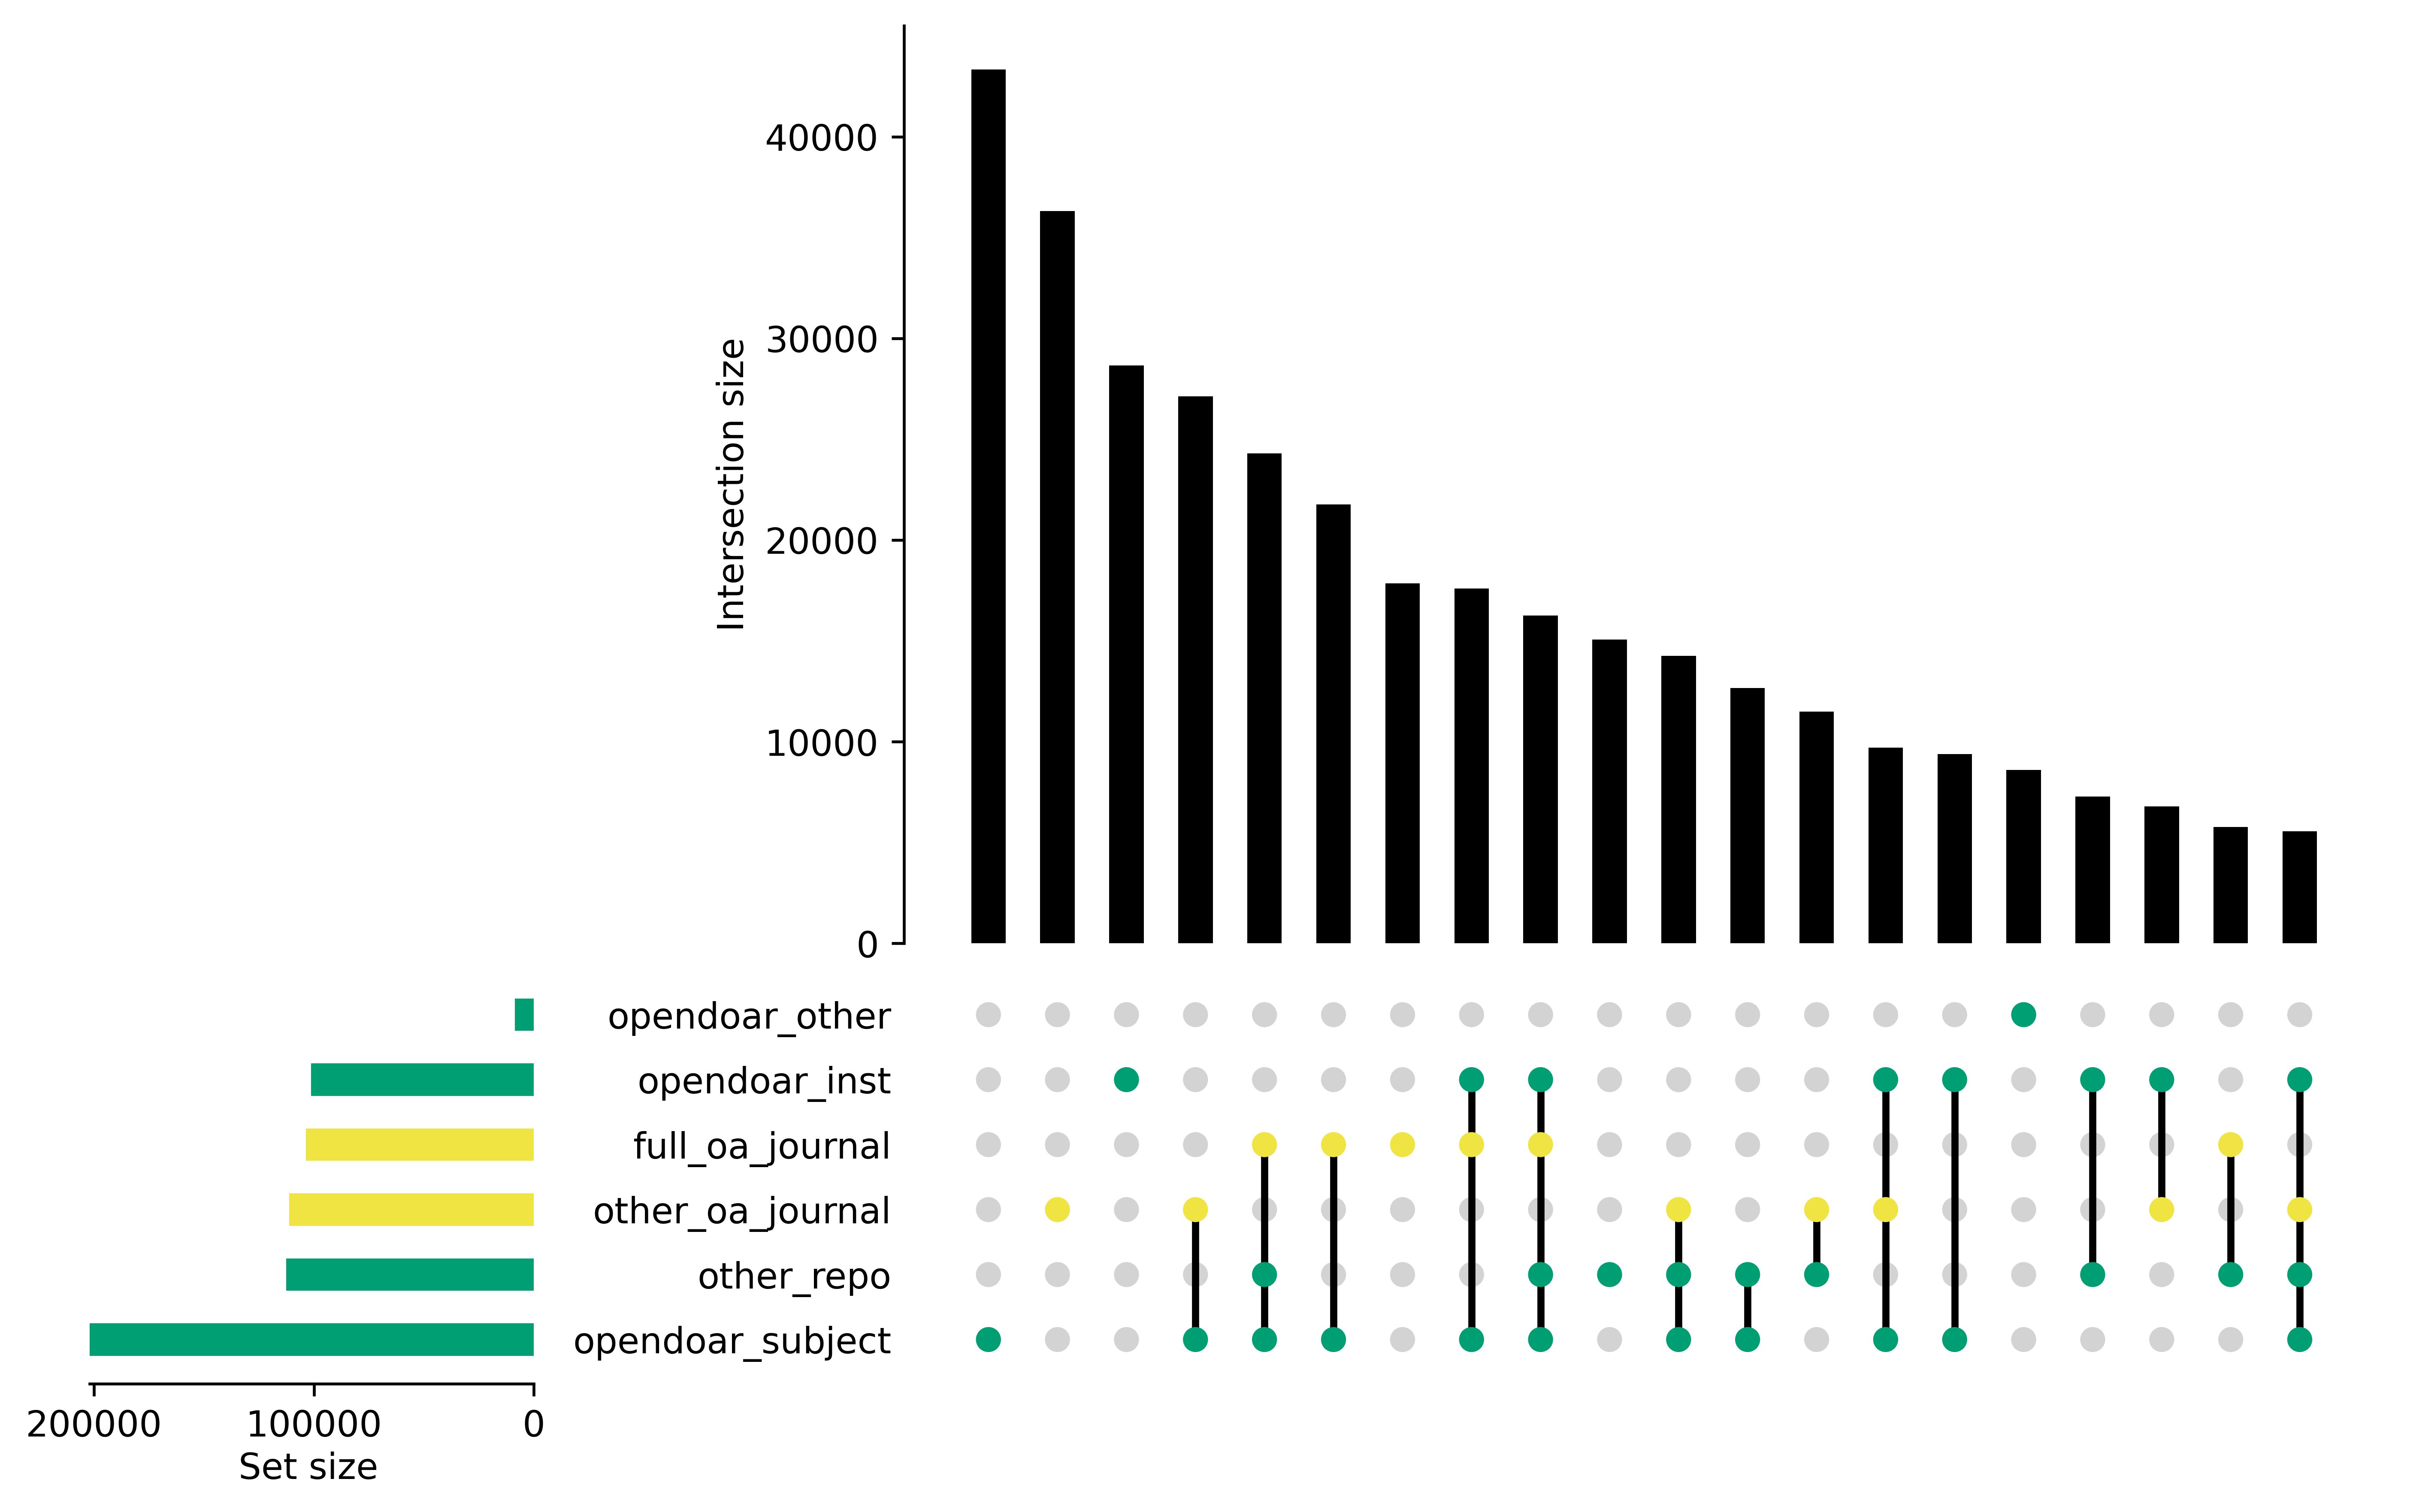

In [8]:
fig = plt.figure(figsize=(10,6))

axes = UpSet(evidence_upset_expr, 
                sort_by='cardinality',
                sort_categories_by='cardinality',
                element_size=20, 
                intersection_plot_elements=13, 
                totals_plot_elements=6,
                color_by_row={'full_oa_journal': '#f0e442', 
                              'other_oa_journal': '#f0e442',
                              'opendoar_other': '#009e73',
                              'opendoar_inst': '#009e73',
                              'other_repo': '#009e73',
                              'opendoar_subject': '#009e73'
                             },
                totals_as_row=True,
                subset_size='sum'
               ).plot(fig=fig)

axes['intersections'].yaxis.grid(False)

axes['totals'].xaxis.grid(False)

plt.subplots_adjust(left=0, bottom=0, right=1.05, top=1, wspace=0, hspace=0)

lgd = fig.text(0.1, -0.07, 'Set size', ha='center', 
         fontdict={'fontsize': 10, 'fontweight': 500})

fig.delaxes(axes['shading'])

fig.savefig('upw_upset_color_row.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    
plt.show()